# 聊天记录综合分析报告

本项目旨在对微信聊天记录进行深入分析。通过利用 Python 的数据分析和可视化库，我们将从多个维度探索聊天数据，包括消息活跃度、发言习惯、关键词云、情绪变化趋势以及消息类型分布等。

分析流程如下：
1.  **环境设置与数据准备**：配置必要的库和字体，加载并清洗数据。
2.  **基本统计**：分析总体消息量、各成员发言量等。
3.  **活跃度分析**：探究在不同时间尺度（按天、按小时）下的消息频率。
4.  **文本内容分析**：通过词云图展示高频词汇。
5.  **情绪分析**：利用 `PaddleHub` 的预训练模型分析消息的情绪倾向，并可视化情绪随时间的变化。
6.  **消息类型分析**：统计不同消息类型（文本、图片、表情包等）的分布情况。

## 1. 环境设置与数据准备

在这一步，我们将安装并导入所有分析所需的库，配置Matplotlib以正确显示中文，然后加载并预处理我们的聊天数据。

In [8]:
# -*- coding: utf-8 -*-
import os
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import jieba

from collections import Counter
import re
import requests # 用于AI报告
from pyecharts.charts import Calendar # 用于热力图
from pyecharts import options as opts # 用于热力图

# 设置字体为 'SimHei'
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

print("\n所有库导入完毕，字体配置完成。")


所有库导入完毕，字体配置完成。


In [9]:
# 3. 加载和预处理数据
def load_and_preprocess_data(json_path):
    print(f"开始从 {json_path} 加载数据...")
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"错误：找不到文件 {json_path}。请确保文件名和路径正确。")
        return None
    except json.JSONDecodeError:
        print(f"错误：无法解析 {json_path}。请检查文件格式是否为有效的JSON。")
        return None

    # 处理嵌套的JSON，提取消息列表
    # 如果 'messages' 键存在，则使用其值；否则，假定整个文件就是消息列表
    data = data.get('messages', data)

    # 转换为DataFrame
    df = pd.DataFrame(data)
    print(f"成功加载 {len(df)} 条消息。")

    # --- 数据清洗和特征工程 ---
    rename_map = {
        'formattedTime': 'time',
        'senderDisplayName': 'sender'
    }
    df.rename(columns=rename_map, inplace=True)
    # 转换时间戳
    df['time'] = pd.to_datetime(df['time'])
    
    # 提取日期和小时
    df['date'] = df['time'].dt.date
    df['hour'] = df['time'].dt.hour
    
    # 提取消息类型
    # 'type' 列可能不存在，使用 .get() 避免错误
    df['message_type'] = df.apply(lambda row: row.get('type', '未知'), axis=1)

    print("数据预处理完成。")
    
    return df

# --- 执行数据加载 ---
# 定义文件路径
JSON_FILE_PATH = 'data.json'

# 加载数据
chat_df = load_and_preprocess_data(JSON_FILE_PATH)

print("\n数据加载完成")   

开始从 data.json 加载数据...
成功加载 9961 条消息。
数据预处理完成。

数据加载完成


## 2. 基本统计分析

在数据准备好之后，我们首先进行一些基本的统计，以了解聊天概况，例如总消息量、每个成员的发言量等。

总消息数: 9961
\n--- 每人发言数量 ---
sender
好友    6204
我     3757
Name: count, dtype: int64


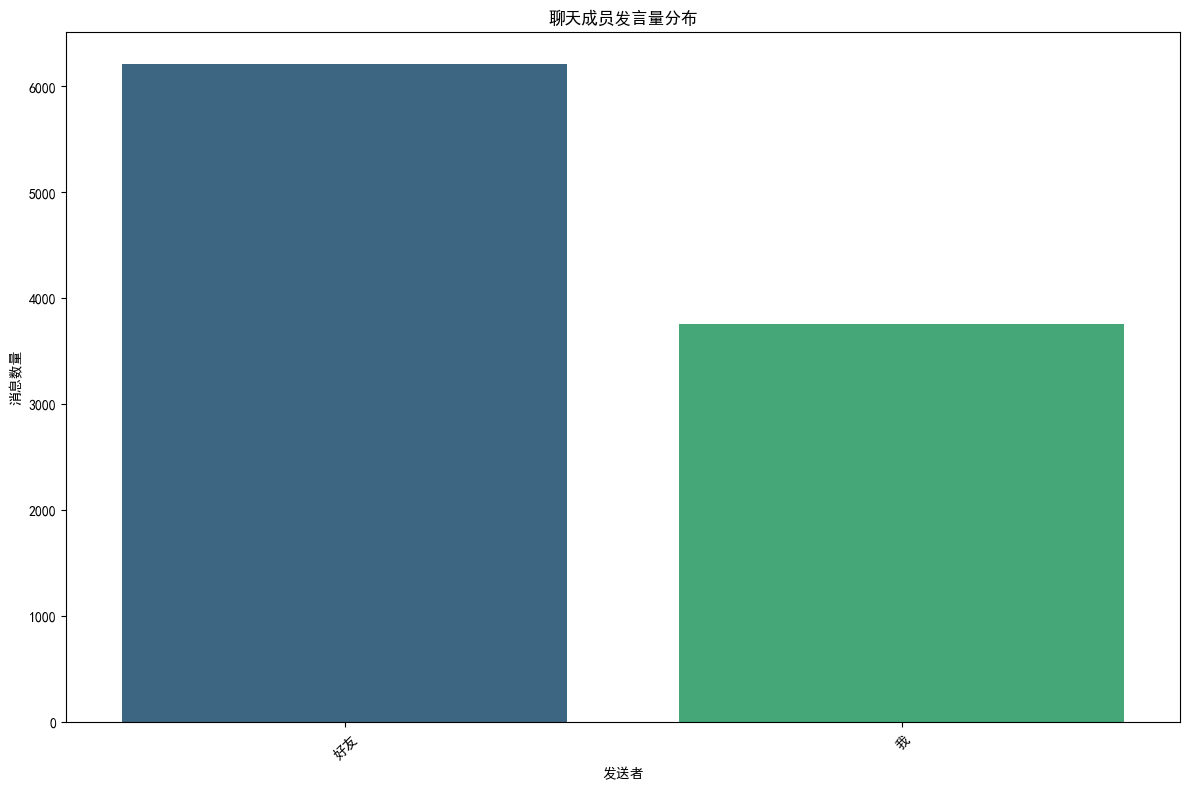

\n--- 消息类型分布 ---
message_type
文本消息                  7760
动画表情                   804
图片消息                   454
引用消息                   406
语音消息                   178
图文消息                    92
聊天记录合并转发                69
卡片式链接                   46
系统消息                    44
文件消息                    27
通话消息                    24
视频消息                    22
转账卡片                    20
位置消息                     4
拍一拍消息                    4
未知类型(219043332145)       2
未知类型(141733920817)       2
红包卡片                     1
小程序分享                    1
未知类型(73014444081)        1
Name: count, dtype: int64


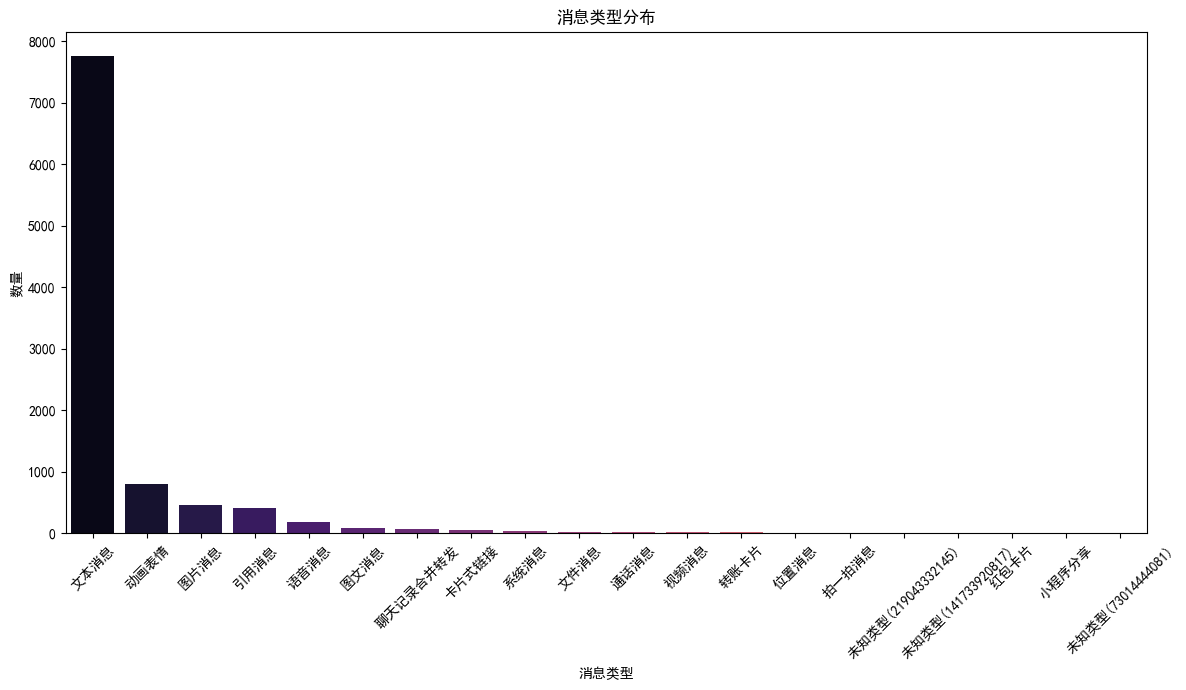

In [10]:
if 'chat_df' in locals() and chat_df is not None:
    # --- 基本统计 ---
    # 计算总消息数
    total_messages = len(chat_df)
    print(f"总消息数: {total_messages}")

    # 计算每个发送者的消息数
    sender_counts = chat_df['sender'].value_counts()
    print("\\n--- 每人发言数量 ---")
    print(sender_counts)

    # 可视化发言人分布
    plt.figure(figsize=(12, 8))
    sns.barplot(x=sender_counts.index, y=sender_counts.values, palette='viridis')
    plt.title('聊天成员发言量分布')
    plt.xlabel('发送者')
    plt.ylabel('消息数量')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- 消息类型分析 (合并) ---
    message_type_counts = chat_df['message_type'].value_counts()
    print("\\n--- 消息类型分布 ---")
    print(message_type_counts)
    
    # 可视化消息类型分布
    plt.figure(figsize=(12, 7))
    sns.barplot(x=message_type_counts.index, y=message_type_counts.values, palette='magma')
    plt.title('消息类型分布')
    plt.xlabel('消息类型')
    plt.ylabel('数量')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("数据未成功加载，请先执行前面的数据加载步骤。")

## 3. 活跃度分析

本部分将分析聊天活跃度随时间的变化趋势，包括每日消息量和每小时消息分布。

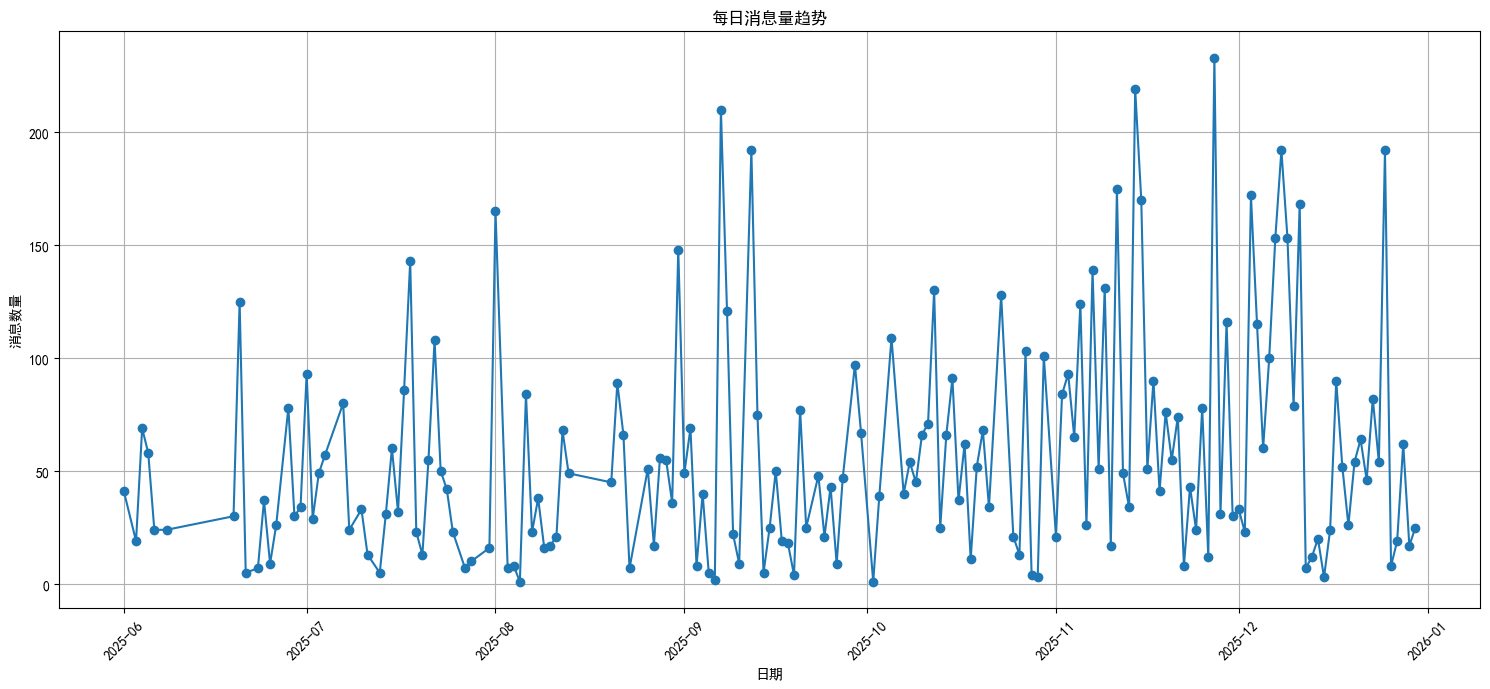

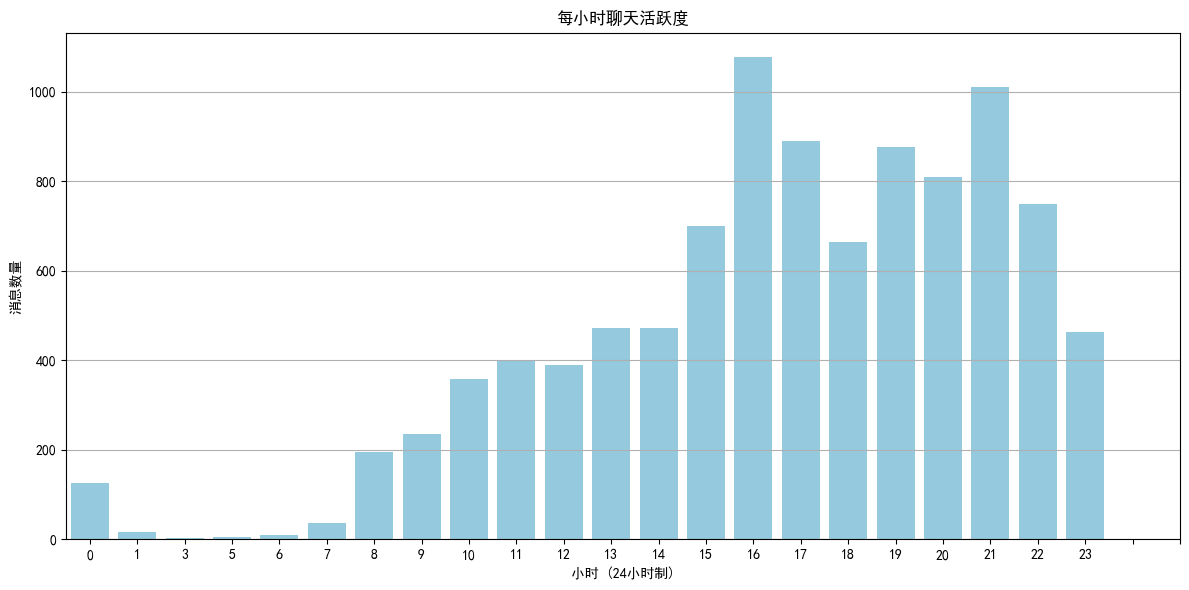

In [ ]:
if 'chat_df' in locals() and chat_df is not None:
    # --- 每日消息趋势 ---
    daily_trend = chat_df.groupby('date').size()
    
    plt.figure(figsize=(15, 7))
    daily_trend.plot(kind='line', marker='o', linestyle='-')
    plt.title('每日消息量趋势')
    plt.xlabel('日期')
    plt.ylabel('消息数量')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- 每日聊天数量热力图 ---
    # 确保 daily_trend 的索引是 datetime 类型
    daily_trend.index = pd.to_datetime(daily_trend.index)
    date_range = pd.date_range(start=daily_trend.index.min(), end=daily_trend.index.max(), freq='D')
    daily_trend = daily_trend.reindex(date_range, fill_value=0)
    
    data = [[date.strftime('%Y-%m-%d'), count] for date, count in daily_trend.items()]
    
    min_year = daily_trend.index.min().year
    max_year = daily_trend.index.max().year
    
    calendar = (
        Calendar()
        .add("", data, calendar_opts=opts.CalendarOpts(range_=[str(min_year), str(max_year)]))
        .set_global_opts(
            title_opts=opts.TitleOpts(title=f"{min_year}-{max_year} 聊天热力图"),
            visualmap_opts=opts.VisualMapOpts(
                max_=int(daily_trend.max() * 1.1) if daily_trend.max() > 0 else 1, # 避免max为0
                min_=0,
                orient="horizontal",
                is_piecewise=False,
                pos_top="230px",
                pos_left="center",
            ),
        )
    )
    
    # --- 每小时活跃度分布 ---
    hourly_activity = chat_df.groupby('hour').size()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=hourly_activity.index, y=hourly_activity.values, color='skyblue')
    plt.title('每小时聊天活跃度')
    plt.xlabel('小时 (24小时制)')
    plt.ylabel('消息数量')
    plt.xticks(range(0, 24))
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
    # 将 pyecharts 图表作为单元格的最后输出来渲染
    calendar.render_notebook()

else:
    print("数据未成功加载，请先执行前面的数据加载步骤。")

## 4. 文本内容分析 (词云)

为了直观地展示聊天中最常讨论的话题，我们创建一个词云。这需要提取所有文本消息，使用`jieba`进行中文分词，并过滤掉常见的停用词。

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.cache
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.cache


成功从 stop words.txt 加载 4011 个停用词。


Loading model cost 0.941 seconds.
Prefix dict has been built successfully.
Prefix dict has been built successfully.


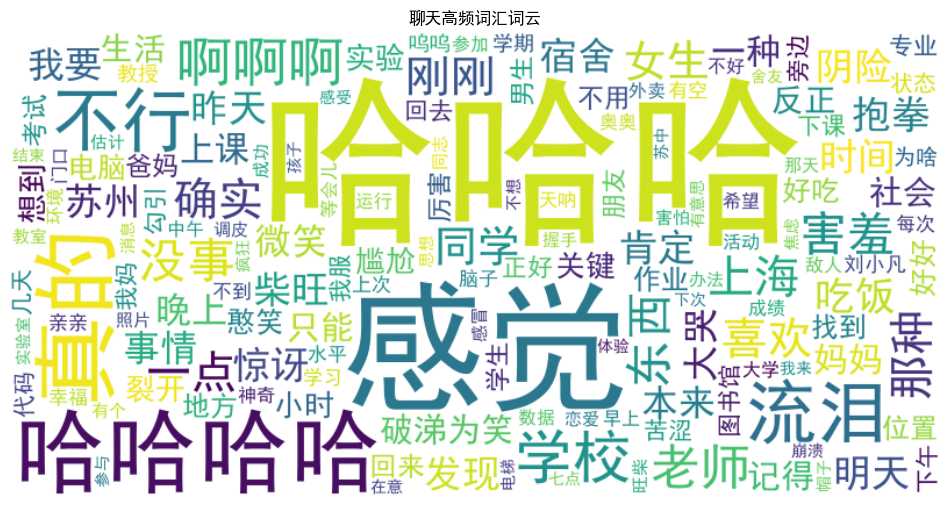

In [5]:
if 'chat_df' in locals() and chat_df is not None:
    # --- 词云生成 ---
    
    # 1. 从文件加载停用词
    def load_stopwords(filepath):
        """从文件加载停用词列表"""
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                stopwords = {line.strip() for line in f}
            print(f"成功从 {filepath} 加载 {len(stopwords)} 个停用词。")
            # 添加一些默认的、可能缺失的停用词
            stopwords.update(["图片", "表情", "语音", "视频", "文件", "红包", "转账", "链接", "[图片]", "[表情]", "撤回了一条消息", "拍了拍"])
            return stopwords
        except FileNotFoundError:
            print(f"错误：找不到停用词文件 {filepath}。请确保文件存在。")
            return set()

    stopwords_path = 'stop words.txt'
    stopwords = load_stopwords(stopwords_path)

    # 2. 提取所有文本消息
    # 确保只处理 'Text' 类型的消息，并且内容是字符串
    text_messages = chat_df[chat_df['message_type'] == '文本消息']['content'].dropna().astype(str)
    full_text = " ".join(text_messages)

    # 3. 中文分词
    # 使用正则表达式去除所有非中文字符，只保留汉字用于分词
    chinese_only_text = re.sub(r"[^\u4e00-\u9fa5]+", "", full_text)
    words = jieba.cut(chinese_only_text)
    
    # 4. 过滤停用词
    filtered_words = [word for word in words if len(word) > 1 and word not in stopwords]
    
    # 5. 检查过滤后是否还有词
    if not filtered_words:
        print("⚠️ 警告：在过滤停用词后，没有剩余的词语可用于生成词云。")
        print("这可能是因为：")
        print("1. 聊天记录中的文本内容过少。")
        print("2. 停用词列表过于宽泛，过滤掉了所有词语。")
        print("请检查您的数据和 'stop words.txt' 文件。")
    else:
        # 6. 生成词云
        word_freq = Counter(filtered_words)
        
        # 选择一个系统中可能存在的中文字体
        font_path = 'C:/Windows/Fonts/simhei.ttf'
        if not os.path.exists(font_path):
            print(f"警告: 找不到字体 {font_path}。词云可能无法正确显示中文。")
            print("请根据您的操作系统修改为正确的字体路径。")
            # 在Windows上，可以尝试 'msyh.ttc' (微软雅黑)
            font_path = 'C:/Windows/Fonts/msyh.ttc' 
            if not os.path.exists(font_path):
                font_path = None # 如果都找不到，则不指定字体路径

        try:
            wordcloud = WordCloud(
                width=800, 
                height=400, 
                background_color='white',
                font_path=font_path, # 指定中文字体路径
                stopwords=stopwords,
                max_words=150,
                colormap='viridis'
            ).generate_from_frequencies(word_freq)

            plt.figure(figsize=(12, 8))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title('聊天高频词汇词云')
            plt.show()
        except Exception as e:
            print(f"生成词云时发生错误: {e}")
            if "font" in str(e).lower():
                print("错误很可能与字体有关。请检查 `font_path` 是否指向一个有效的中文字体文件。")

else:
    print("数据未成功加载，请先执行前面的数据加载步骤。")

## 5. 情绪分析

本节利用`PaddleHub`的`ernie_skep_sentiment_analysis`模型对文本消息进行情绪分析。我们将分析整体的情绪分布，并探究情绪随时间的变化趋势。

d:\Anaconda\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
d:\Anaconda\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
d:\Anaconda\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


📊 双人聊天记录分析中... 总文本数量: 7760 条
🔄 正在加载模型 (uer/roberta-base-finetuned-jd-binary-chinese)...
✅ 模型就绪，开始分析...
✅ 模型就绪，开始分析...
进度: 7600/7760
🎉 分析完成！正在生成双人对比报告...

🎉 分析完成！正在生成双人对比报告...


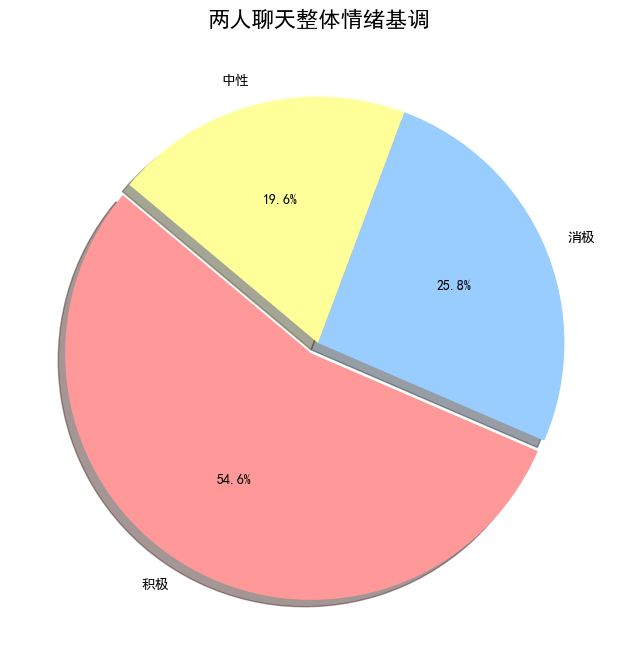

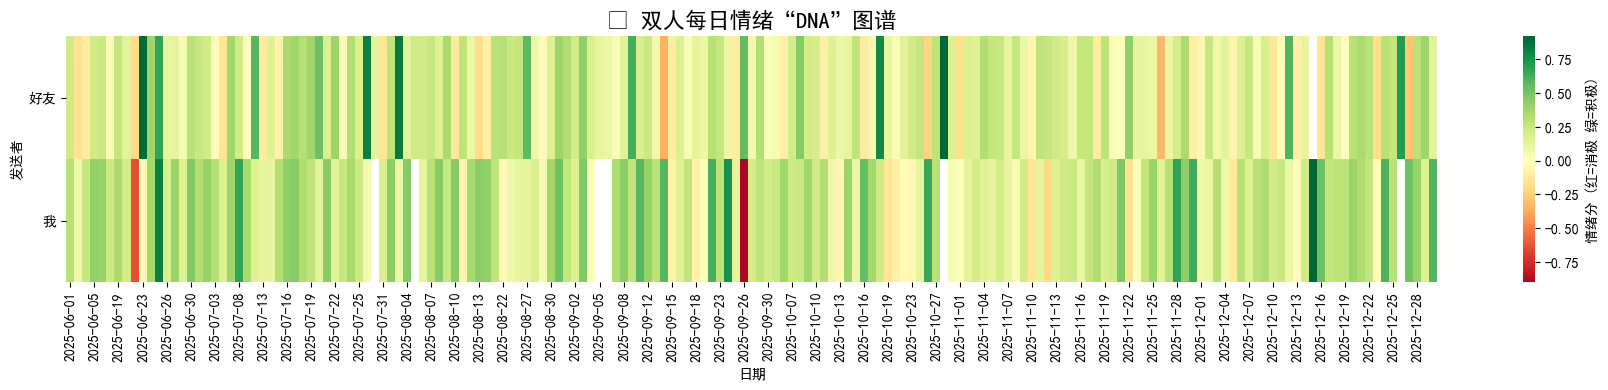

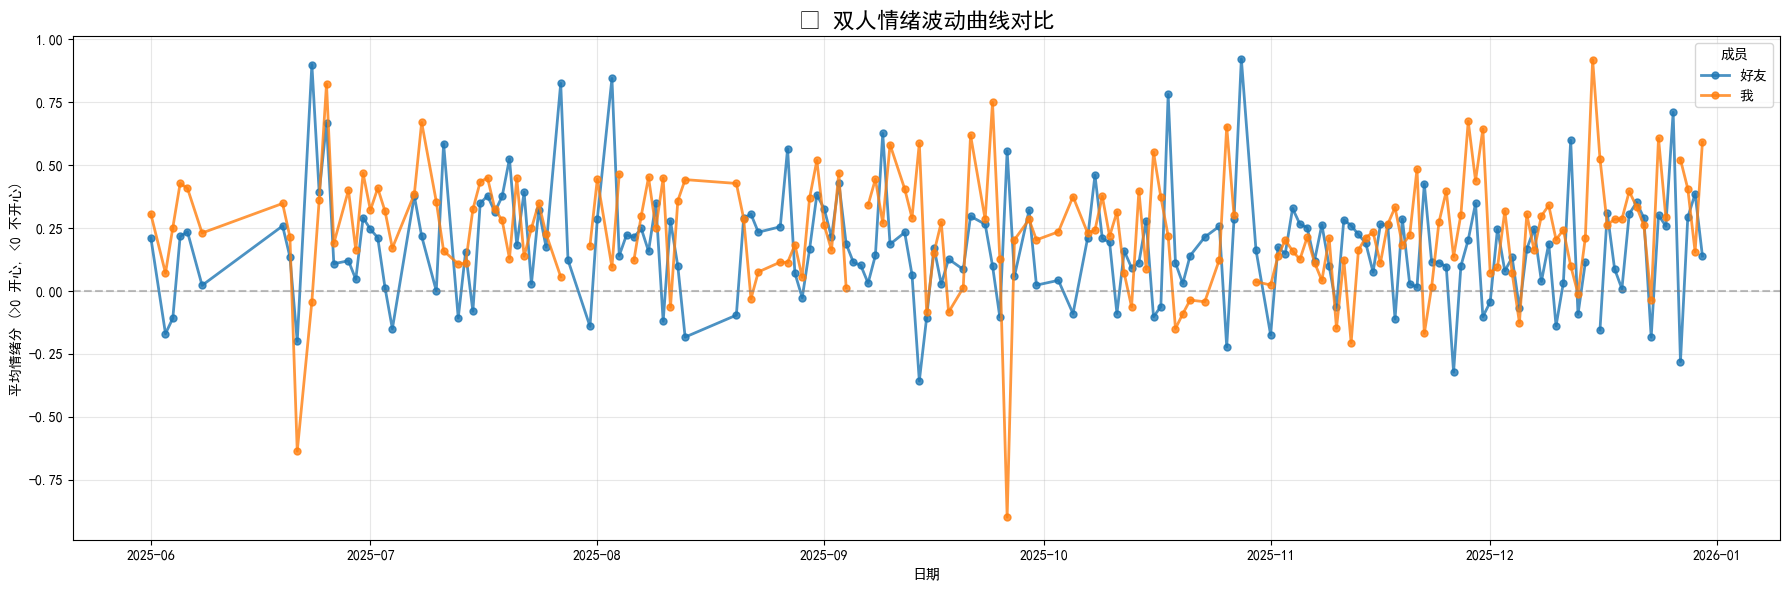


📝 --- 双人关系分析报告 --- 📝
整体来看：
👤 我 的平均情绪指数为: 0.25
👤 好友 的平均情绪指数为: 0.16
💡 结论: 你们的情绪状态非常同步！

⚡ 全程最“炸毛”的一句话出现在 2025-10-30:
   好友: 完*


In [6]:
# ==========================================
# 1. 环境与配置
import os
# 防止 OpenMP 冲突
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# 使用国内镜像加速模型下载
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import warnings

warnings.filterwarnings("ignore")
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False

device = -1 # 使用 CPU

# ==========================================
# 2. 准备数据 (双人模式)
# ==========================================
if 'chat_df' in locals() and chat_df is not None:
    # 提取关键列
    text_df = chat_df[chat_df['message_type'] == '文本消息'][['content', 'date', 'hour', 'sender']].copy()
    text_df.dropna(subset=['content'], inplace=True)
    text_df['content'] = text_df['content'].astype(str).str.strip()
    text_df = text_df[text_df['content'] != '']
    
    total_count = len(text_df)
    print(f"📊 双人聊天记录分析中... 总文本数量: {total_count} 条")
    
    # 既然是作业且追求精准，我们直接跑全量
    analysis_df = text_df.copy()    
    text_list = analysis_df['content'].tolist()

    # ==========================================
    # 3. 加载模型 & 推理
    # ==========================================
    print("🔄 正在加载模型 (uer/roberta-base-finetuned-jd-binary-chinese)...")
    model_name = "uer/roberta-base-finetuned-jd-binary-chinese"
    
    try:
        classifier = pipeline("sentiment-analysis", model=model_name, device=device)
        print("✅ 模型就绪，开始分析...")

        results = []
        for i, text in enumerate(text_list):
            try:
                res = classifier(text[:512])[0]
                results.append(res)
            except:
                results.append({'label': 'neutral', 'score': 0.5})
            
            if (i + 1) % 200 == 0:
                print(f"进度: {i + 1}/{len(text_list)}", end='\r')
        
        print("\n🎉 分析完成！正在生成双人对比报告...")

        # ==========================================
        # 4. 数据处理：计算分数
        # ==========================================
        probs = []
        final_labels = [] 
        
        for res in results:
            label = res['label']
            score = res['score']
            
            if 'positive' in label:
                prob = score
            else:
                prob = 1 - score 
            
            probs.append(prob)
            
            # 0.4 - 0.6 之间算中性
            if prob >= 0.6:
                final_labels.append('积极')
            elif prob <= 0.4:
                final_labels.append('消极')
            else:
                final_labels.append('中性')

        analysis_df['positive_prob'] = probs
        analysis_df['sentiment'] = final_labels
        # 计算数值分：积极=1, 中性=0, 消极=-1，用于画线
        analysis_df['sentiment_score'] = (analysis_df['positive_prob'] - 0.5) * 2

        # ==========================================
        # 5. 可视化展示 (Pie + Heatmap + Line)
        # ==========================================
        
        # --- 图表 1: 整体情绪分布饼图 (保留你想要的) ---
        plt.figure(figsize=(8, 8))
        counts = analysis_df['sentiment'].value_counts()
        colors = {'积极': '#ff9999', '中性': '#ffff99', '消极': '#99ccff'} # 粉红、淡黄、天蓝
        
        # 绘制饼图
        patches, texts, autotexts = plt.pie(
            counts, 
            labels=counts.index, 
            autopct='%1.1f%%', 
            colors=[colors.get(x, '#cccccc') for x in counts.index], 
            startangle=140,
            explode=(0.05, 0, 0) if len(counts) == 3 else None, #稍微突出第一块
            shadow=True
        )
        plt.title('两人聊天整体情绪基调', fontsize=16)
        plt.show()

        # --- 图表 2: 每日情绪热力图 (双人并排) ---
        # 制作透视表：行=人，列=日期
        heatmap_data = analysis_df.pivot_table(index='sender', columns='date', values='sentiment_score', aggfunc='mean')
        
        # 动态调整高度：因为只有2行，高度设小一点，宽度设大一点
        plt.figure(figsize=(18, 4)) 
        sns.heatmap(
            heatmap_data, 
            cmap='RdYlGn', # 红黄绿配色
            center=0, 
            annot=False,   # 不显示数字，太乱
            cbar_kws={'label': '情绪分 (红=消极 绿=积极)'},
            square=False   # 允许长方形格子
        )
        plt.title('📅 双人每日情绪“DNA”图谱', fontsize=16)
        plt.xlabel('日期')
        plt.ylabel('发送者')
        plt.yticks(rotation=0) # 名字横着放
        plt.tight_layout()
        plt.show()

        # --- 图表 3: 双人情绪波动折线图 ---
        plt.figure(figsize=(18, 6))
        
        # 按 日期 和 人 分组
        daily_trend = analysis_df.groupby(['date', 'sender'])['sentiment_score'].mean().unstack()
        
        # 自动画出两列（两个人）
        daily_trend.plot(
            kind='line', 
            marker='o', 
            markersize=5, 
            linewidth=2,
            alpha=0.8,
            ax=plt.gca()
        )
        
        plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
        plt.title('📈 双人情绪波动曲线对比', fontsize=16)
        plt.ylabel('平均情绪分 (>0 开心, <0 不开心)')
        plt.xlabel('日期')
        plt.grid(True, alpha=0.3)
        plt.legend(title='成员', loc='best')
        plt.tight_layout()
        plt.show()

        # ==========================================
        # 6. 文字报告
        # ==========================================
        print("\n📝 --- 双人关系分析报告 --- 📝")
        
        senders = analysis_df['sender'].unique()
        if len(senders) == 2:
            p1, p2 = senders[0], senders[1]
            
            s1 = analysis_df[analysis_df['sender']==p1]['sentiment_score'].mean()
            s2 = analysis_df[analysis_df['sender']==p2]['sentiment_score'].mean()
            
            print(f"整体来看：")
            print(f"👤 {p1} 的平均情绪指数为: {s1:.2f}")
            print(f"👤 {p2} 的平均情绪指数为: {s2:.2f}")
            
            if abs(s1 - s2) < 0.1:
                print("💡 结论: 你们的情绪状态非常同步！")
            elif s1 > s2:
                print(f"💡 结论: {p1} 在聊天中表现得更乐观一些。")
            else:
                print(f"💡 结论: {p2} 在聊天中表现得更乐观一些。")

        # 抓取最低谷的时刻
        worst_idx = analysis_df['sentiment_score'].idxmin()
        worst_row = analysis_df.loc[worst_idx]
        print(f"\n⚡ 全程最“炸毛”的一句话出现在 {worst_row['date']}:")
        print(f"   {worst_row['sender']}: {worst_row['content']}")

    except Exception as e:
        print(f"❌ 发生错误: {e}")
else:
    print("请先加载数据")

## 7. AI 生成的分析报告 (DeepSeek)

本部分将利用 `chat_analyzer.py` 中的功能，调用外部的 AI 模型（如 DeepSeek）来生成一份关于聊天内容的摘要和分析报告。这可以提供一个更宏观、更具洞察力的视角。

In [7]:
def generate_ai_report(api_key, chat_dataframe, top_n=10):
    """
    使用DeepSeek API生成聊天记录的AI分析报告。
    
    Args:
        api_key (str): DeepSeek API密钥。
        chat_dataframe (pd.DataFrame): 包含聊天记录的DataFrame。
        top_n (int): 用于分析的最高频词数量。
    """
    if not api_key or api_key == "YOUR_DEEPSEEK_API_KEY":
        print("⚠️ 警告：未提供有效的DeepSeek API Key。跳过AI报告生成。")
        print("请访问 https://platform.deepseek.com/api_keys 获取您的密钥。")
        return

    print("\\n" + "="*60)
    print("🤖 正在生成AI分析报告 (Powered by DeepSeek)...")
    print("="*60)

    # 1. 准备报告所需的数据
    total_messages = len(chat_dataframe)
    duration_days = (chat_dataframe['date'].max() - chat_dataframe['date'].min()).days
    sender_counts = chat_dataframe['sender'].value_counts()
    
    # 准备文本内容进行分词
    text_content = " ".join(chat_dataframe[chat_dataframe['message_type'] == 'Text']['content'].dropna().astype(str))
    words = [word for word in jieba.cut(text_content) if len(word) > 1 and word not in stopwords]
    top_words = Counter(words).most_common(top_n)

    # 2. 构建Prompt
    prompt = f"""
    请根据以下聊天数据摘要，生成一份简短、深刻的中文分析报告。报告应包括：
    1.  对整体聊天风格和氛围的总结。
    2.  对主要参与者的沟通模式的简要分析。
    3.  基于高频词汇，推断出他们可能的核心话题或关系特点。
    4.  提出一两个有趣的观察或结论。

    **数据摘要:**
    - **时间跨度**: {duration_days} 天
    - **总消息数**: {total_messages} 条
    - **参与者消息分布**:
"""
    for sender, count in sender_counts.items():
        prompt += f"      - {sender}: {count} 条 ({count/total_messages:.1%})\\n"
    
    prompt += f"- **讨论的 Top {top_n} 高频词汇**: {', '.join([word for word, count in top_words])}\\n"

    prompt += "\n**分析报告:**\n"

    # 3. 调用API
    try:
        url = "https://api.deepseek.com/chat/completions"
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }
        payload = {
            "model": "deepseek-chat",
            "messages": [
                {"role": "system", "content": "你是一位精通社会学和心理学的数据分析师，擅长从沟通数据中发现深层关系和模式。"},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.7,
            "stream": False
        }
        
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status() # 如果请求失败则抛出异常
        
        result = response.json()
        report_content = result['choices'][0]['message']['content']
        
        print("--- AI 分析报告 ---")
        print(report_content)
        print("--------------------")

    except requests.exceptions.RequestException as e:
        print(f"❌ 调用AI报告API时出错: {e}")
    except (KeyError, IndexError):
        print("❌ 解析AI报告API响应时出错，请检查返回的数据格式。")


# --- 执行AI报告生成 ---
# 读取配置中的DeepSeek API Key
try:
    from config import DEEPSEEK_API_KEY
    api_key = DEEPSEEK_API_KEY
except:
    api_key = None

if 'chat_df' in locals() and chat_df is not None:
    generate_ai_report(api_key, chat_df)
else:
    print("数据未成功加载，请先执行AI报告生成步骤。")

\n============================================================
🤖 正在生成AI分析报告 (Powered by DeepSeek)...
--- AI 分析报告 ---
### 聊天数据分析报告

**1. 整体聊天风格与氛围**

在长达212天的交流中，两位参与者保持了极高频率的互动（日均约47条消息），形成了一个**高度活跃、持续且深入**的沟通环境。从消息分布来看，好友的发言量显著高于“我”（62.3% vs 37.7%），这暗示好友可能在对话中更多地扮演了**话题发起者、信息分享者或情感倾诉者**的角色。整体氛围呈现出**高度信任、相互依赖**的特点，双方愿意分享日常细节、情绪波动和深度思考，而非停留在浅层社交。

**2. 主要参与者沟通模式分析**

*   **好友（主导分享者）**：其沟通模式显示出较强的**表达欲和情感输出倾向**。更高的消息占比可能意味着他/她更习惯于通过叙述来整理思绪、寻求共鸣或获得支持。其发言很可能包含较多的个人经历描述、观点阐述和情绪表达。
*   **我（积极回应者）**：虽然消息总数较少，但在长达七个月的对话中保持近38%的占比，说明“我”绝非被动接收者，而是**持续、稳定的积极回应方**。沟通模式可能侧重于**倾听、追问、提供反馈与情感支持**，通过高质量的互动维持对话的深度与平衡。

**3. 核心话题与关系特点推断**

基于高频词汇分析，可以推断其交流核心远超日常寒暄，聚焦于以下几个层面：

*   **关系轴心：深度情感联结**。词汇“感觉”、“知道”、“真的”高频出现，标志着对话充满了**主观感受的交换、真实性的强调与相互确认**。这不是在交换客观信息，而是在持续构建和校准彼此的情感认知与理解。
*   **核心内容：内省与日常的交织**。“时间”、“现在”、“事情”等词表明，对话紧密围绕**个人生活的具体脉络（日常事件）与时间维度（当下体验、可能还有对过去的回忆或未来的展望）** 展开。“想”字的高频使用，进一步突出了对话的**内省性、思考性和计划性**。
*   **关系特点：紧密的“我们”意识**。“我们”一词位列高频词前列，是至关重要的信号。它表明双方在思考问题时，经常**自发地将彼此置于同一立场或共同情境中**，关系已从“你”和“我”